In [1]:
using Plots
using LinearAlgebra
using SparseArrays

In [68]:
# funcao que resolve 
# Helmholtz em um grid m x m
function helmholtz(m)
    # calcula o espacamento do grid
    h = 2/m
    # constroi a matriz do sistema linear
    # levando em conta as condicoes de contorno
    d_up = ones(m-1)
    d_up[m-1] = 2
    
    d = (-4-10*h*h)*ones(m)
    d[1] = (-4-h-10*h*h)# du/dx = 0.5u
    d[m] = (-4+h-10*h*h)# du/dx = -0.5u
    
    d_down = ones(m-1)
    d_down[1] = 2
    
    A = Tridiagonal(d_down, d, d_up)
    A = kron(sparse(I,m,m),A)
    
    j=1
    for i=m+1:m*m
        A[i,j] = 1
        A[j,i] = 1
        j+=1
    end
    # mesmo nao sendo ideal
    # transformar a matriz em sparse
    # nesse ponto reduz bastante o 
    # tempo de execucao
    A = sparse(A)
    
    # lado direito do sistema
    # leva em consideracao 
    # as condicoes de Dirichlet
    F = zeros(m*m)   
    F[1:m] .= -1
    # resolve o sistema e retorna
    return A\F,m,h,A
end

helmholtz (generic function with 1 method)

  2.386011 seconds (92 allocations: 2.024 GiB, 0.70% gc time)


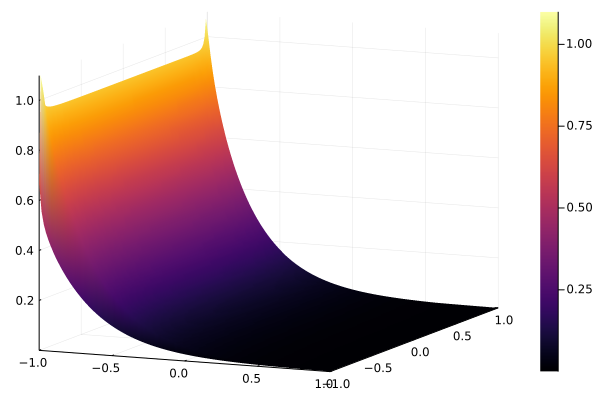

In [71]:
@time U,m,h,A = helmholtz(128)
U = reshape(U,m,m)
x = range(-1,stop=1,length=m)
y = range(-1,stop=1,length=m)
surface(x,y,U)

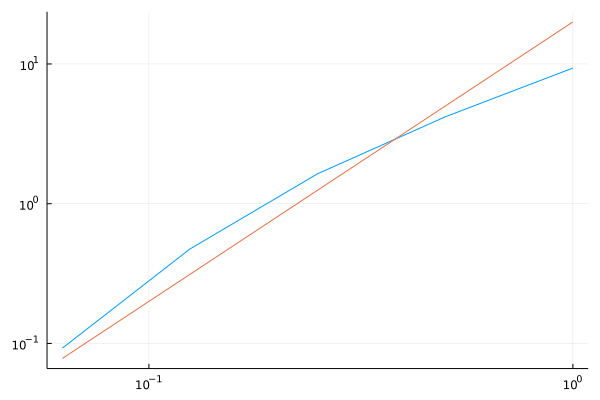

In [101]:
# calcula o grid de referencia
U_fine = helmholtz(2^7)[1]
# cria uma lista com 5 grids
U = [helmholtz(2^i)[1] for i=1:5]

#funcao que calcula o erro
function erro(U,p)          
    # algoritmo para encontrar pontos comuns em grids diferentes
    # explicacao no relatorio
    same_index = [i*2^(7-p) for i=1:2^p]
    same_U_fine = [i+2^7*(j-1) for i in same_index  for j in same_index]
    same_U = [j+2^p*(i-1) for i=1:2^p for j=1:2^p]
    erro = [U[same_U[i]] - U_fine[same_U_fine[i]] for i=1:2^(2*p)]

    return erro
end

# plota um log-log do erro por h
error_list = [norm(erro(U[i],i),2) for i=1:5]
h_list = [2/2^i for i=1:5]
plot(h_list,reverse(error_list),xaxis=:log, yaxis=:log, legend=false, fmt=:png)
plot!(h_list,20*h_list.*h_list)